# Инструмент `Pipeline` в `sklearn`

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

%matplotlib inline

### Данные
 
Датасет состоит из 11 химических признаков вина и таргет-переменная --- качество вина.

In [0]:
winedf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
winedf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Посмотрим, есть ли пропущенные значения

In [0]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Можно и так

In [0]:
winedf['quality'].isnull().sum()

0

Попарные графики

<Figure size 1080x2160 with 0 Axes>

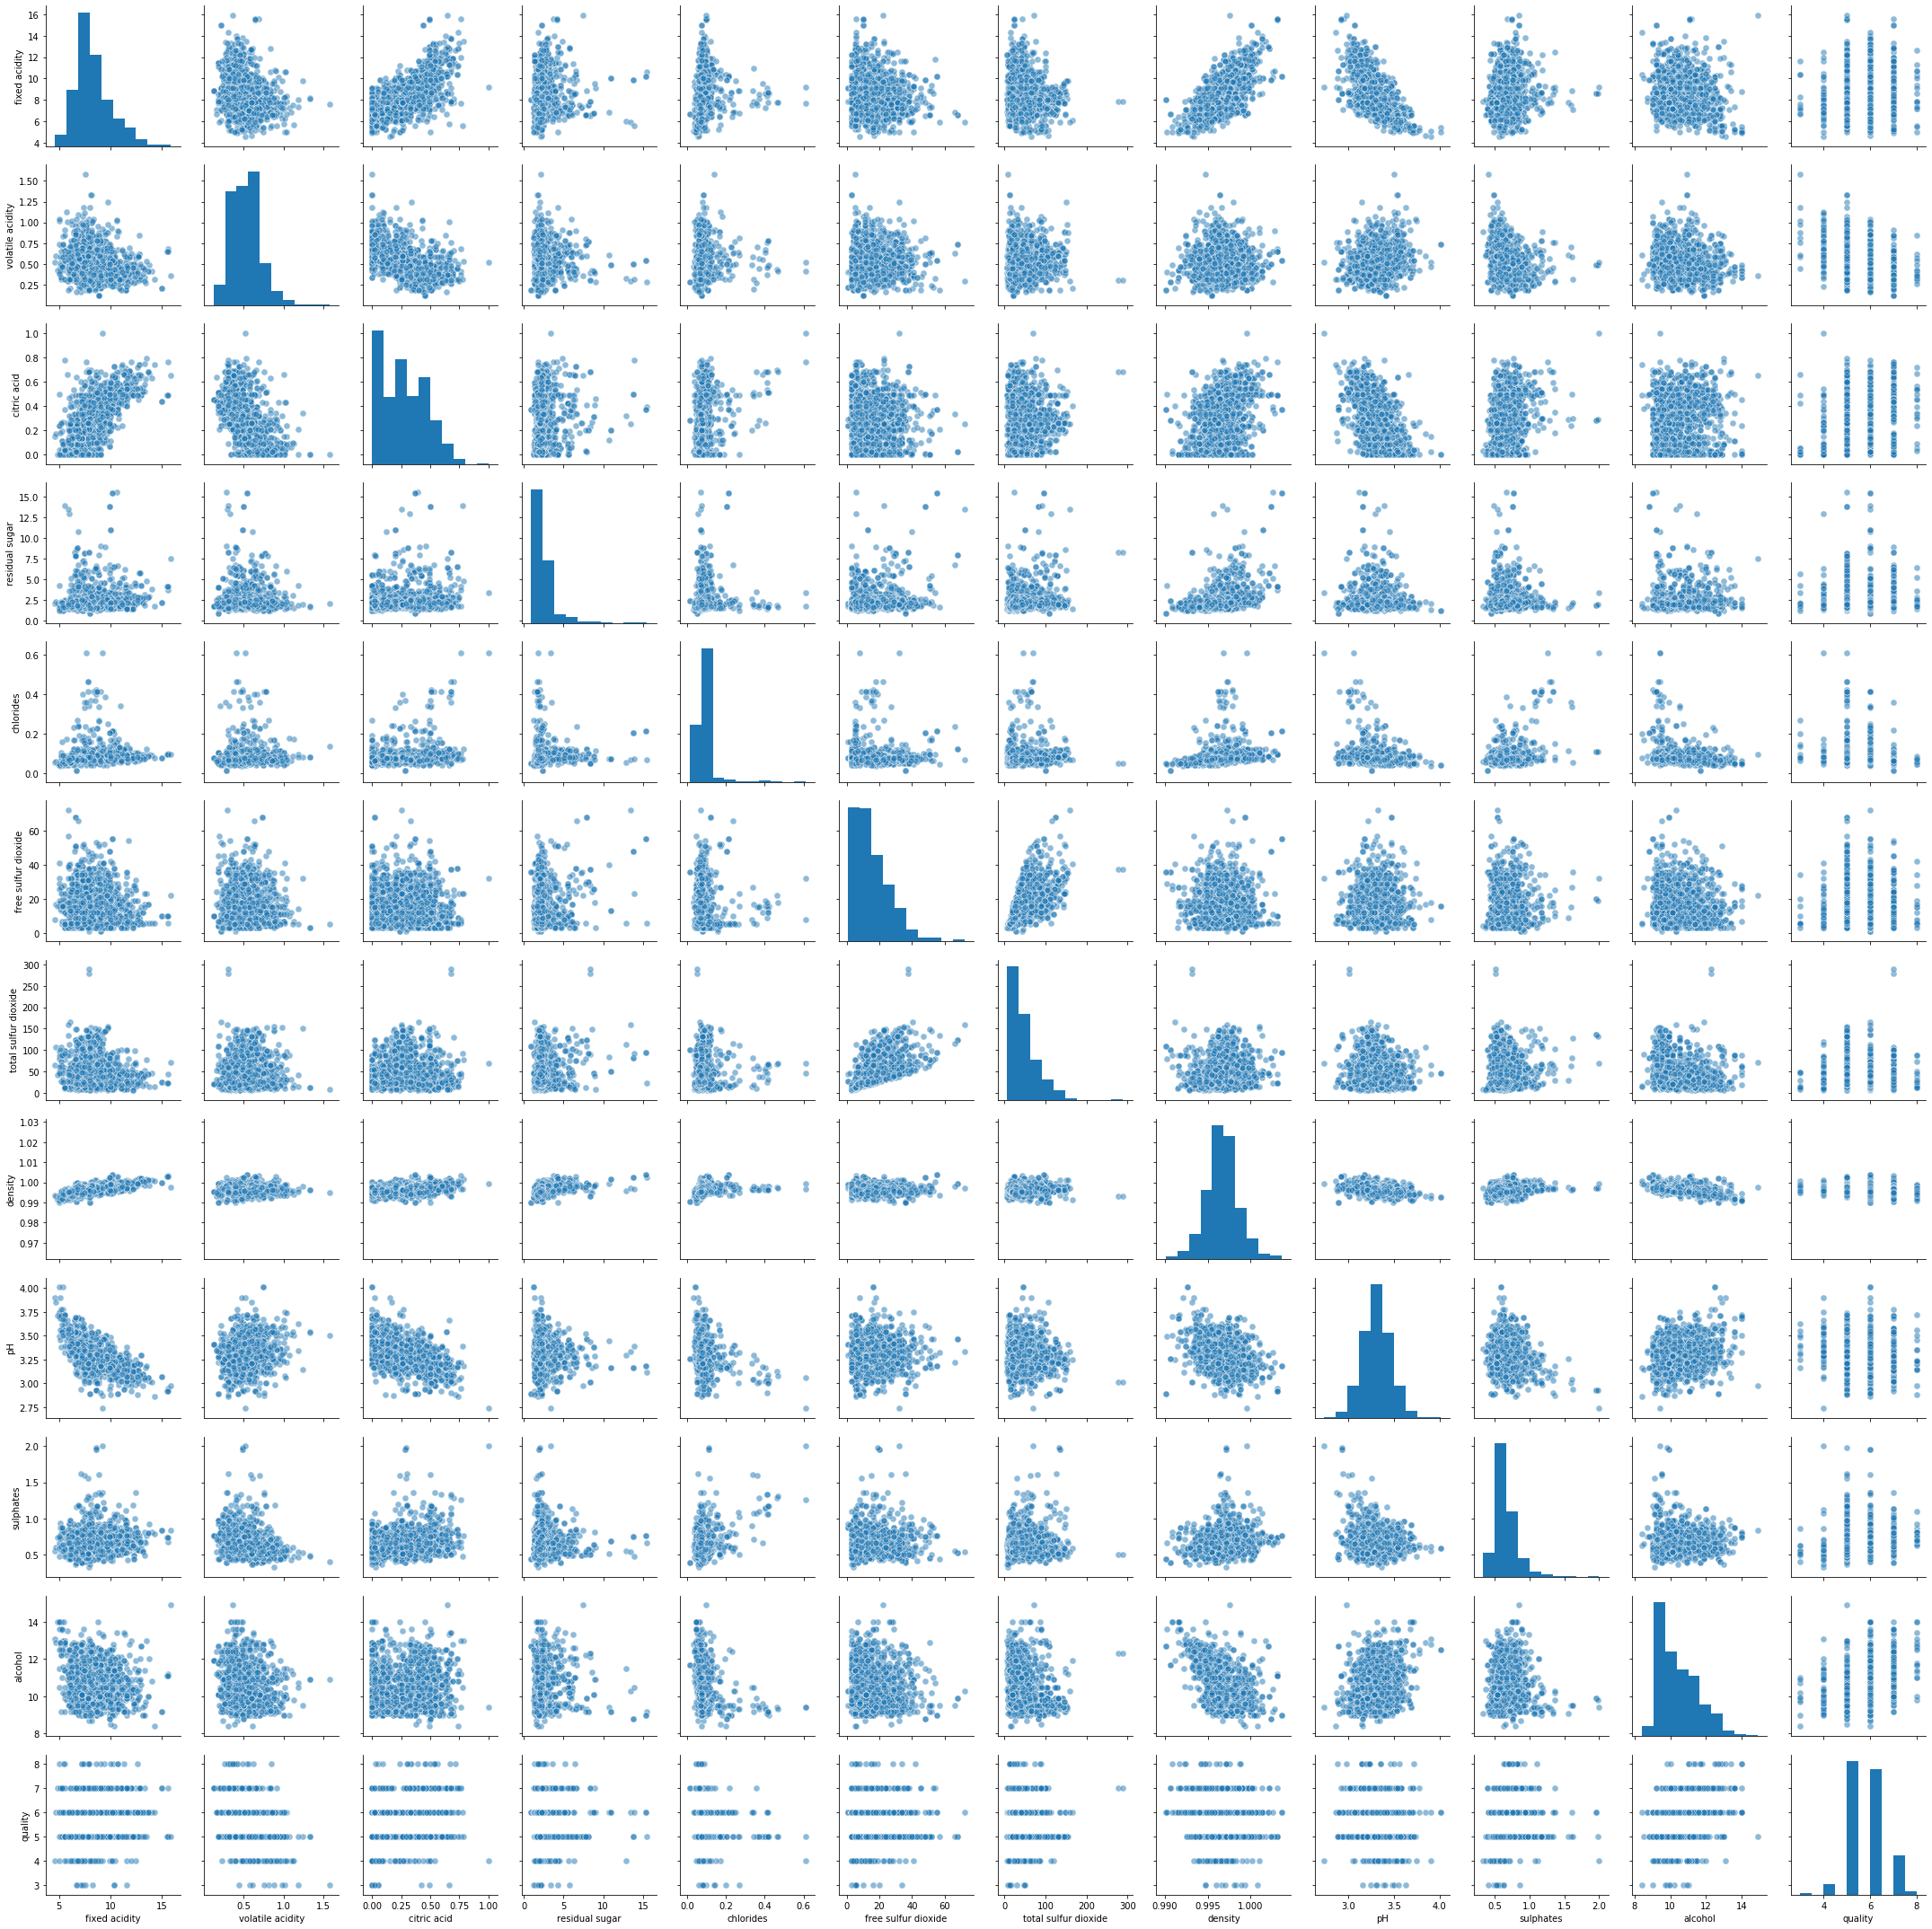

In [0]:
plt.figure(figsize=(15, 30))
sns.pairplot(winedf, plot_kws=dict(s=50, alpha=0.5));

Разделим на X и Y

In [0]:
X = winedf.drop(['quality'],axis=1)
Y = winedf['quality']

# y is a pandas series
print(type(X), type(Y)) 

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


### Пайплайн

Импортим класс классификатора, который будем использовать далее, scaler и класс `Pipline`.<br>
Кроме `StandardScaler` в `sklearn` есть еще набор классов для масштабирования: <br>
* `MinMaxScaler`
* `MaxAbsScaler`
* `StandardScaler`
* `RobustScaler`
* `Normalizer`
* `QuantileTransformer`
* `PowerTransformer`

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Создаем `Pipeline`. Сначала в данном случае применяем scaler, а потом логистическую регрессию.

In [0]:
steps = [
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(solver='saga', 
                               multi_class='multinomial', 
                               max_iter=5000))
]

pipeline = Pipeline(steps) 

Разделим выборку на train и test. Перед этим посмотрим на распределение классов у target-переменной

In [0]:
winedf['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Распределение классов очень несбалансированное. Поэтому будем использовать стратификацию при разделении на test и train: то есть сделаем разбиение данных так, чтобы распределение классов примерно сохранилось.

In [0]:
X_train, X_test, Y_train, Y_test \
    = train_test_split(X, Y, test_size=0.2, random_state=30, stratify=Y)

На самом деле уже здесь мы можем обучить созданный ранее Pipeline на обучающей выборке и предсказать на тестовой.

Обучаем

In [0]:
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Предсказываем и посмотрим на score, который получается на данных предсказаниях. В качестве скора pipeline берет метрику, которую минимизирует последний классификатор.

In [0]:
prediction = pipeline.predict(X_test)
pipeline.score(X_test, Y_test)

0.584375

### Пайплайн и подбор гиперпараметров

Мы хотим подобрать оптимальные параметры у классификатора.
У логистической регрессии обычно оптимизируют `penalty` и `C`.

In [0]:
parameteres = {'clf__penalty': ['l1', 'l2'], 
               'clf__C': [0.01, 0.1, 1, 10, 100]}

Теперь создадим объект сетку `GridSearchCV`, которой передадим модель `pipline` и скажем, что будем использовать кросс-валидацию на 5 фолдов

In [0]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

Полученное обучим на обучающей выборке.

In [0]:
%%time
grid.fit(X_train, Y_train)

CPU times: user 19.4 s, sys: 1.61 ms, total: 19.4 s
Wall time: 19.4 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=5000,
                                                           multi_class='mul

И посмотрим на оптимальные параметры

In [0]:
print("score = %3.2f" % (grid.score(X_test, Y_test)))
print(grid.best_params_)

score = 0.58
{'clf__C': 0.1, 'clf__penalty': 'l2'}


## Зачем это вообще нужно?

***1).*** Обеспечивает соблюдение определенного порядка выполнения операций, что способствует воспроизводимости и созданию удобного рабочего процесса.

***2).*** Собираем несколько шагов, которые кросс-валидируем вместе выбирая разные параметры. Можно рассматривать параметры с разных шагов используя их имена и название параметра, разделенные "`__`" (Например, "`clf__gamma`").

***3).*** Применять сначала scaler ко всем данным, а после этого на полученном вызывать gridSearch не совсем корректно. gridSearch на каждом этапе разбивает на train и validate, обучает на train и смотрит результат на validate. Однако в таком случае, train знает что-то о validate, ведь мы до этого применили scaler ко всем данным. Так плохо, по хорошему мы не должны видеть validate до тех пор пока не собирёмся измерять качество модели на нем.